# Imports

In [1]:
import os
import cv2
import rasterio

# from osgeo import gdal

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow
from tensorflow.keras.utils import load_img, img_to_array, array_to_img
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import array_to_img, img_to_array, load_img
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras

from PIL import Image

2023-05-24 20:50:13.622145: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-24 20:50:13.932496: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-05-24 20:50:13.934129: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-24 20:50:15.468429: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Connect to data on local drive & assign working folder

In [2]:
# # Get the absolute path of the current script or notebook
current_path = os.getcwd()

# Get the directory of the current script or notebook
current_directory = os.path.dirname(current_path)

# Define the path to the "AerialImageDataset" folder
absolute_path = os.path.join(current_directory, "data/AerialImageDataset")

# Change the current working directory to the "AerialImageDataset" folder
absolute_path

'/home/abhinav/code/JennyF-slb/solar_ai/data/AerialImageDataset'

# Data loading for all the files for execution

In [3]:
# Construct the absolute path to the "train/images" directory
train_images_dir = os.path.join(absolute_path, 'train', 'images')
test_images_dir = os.path.join(absolute_path, 'test', 'images')
train_gt_dir = os.path.join(absolute_path, 'train', 'gt')

target_shape = (512, 512, 3)  # Target shape for resizing

# Function to load and preprocess GeoTIFF files
def load_geotiff_data(image_folder, target_shape=None, normalize=True):
    file_paths = [os.path.join(image_folder, filename) for filename in sorted(os.listdir(image_folder)) if filename.endswith('.tif')]
    data = []
    for file_path in file_paths:
        dataset = rasterio.open(file_path, "r")
        if dataset is None:
            continue
        image = dataset.read() # Convert to array
        image = np.transpose(image, (1, 2, 0))  # Transpose the position of channels in the image

        if target_shape is not None:
            image = tensorflow.image.resize(image, target_shape[:2]) # Re-shape / re-size the image
            image = image.numpy()
        else:
            target_shape = (image.shape[0], image.shape[1])  # Use the original image shape as the target shape
            image = tensorflow.image.resize(image, target_shape[:2])
            image = image.numpy()

        image = image.astype('float32') / 255.0 # Normalize pixel color values between 0 and 1 from 0 and 255

        # Add the preprocessed image to the data list
        data.append(image)
        dataset.close()  # Close the dataset

    return np.array(data)

In [4]:
# Load and preprocess GeoTIFF, image data as X
X_train = load_geotiff_data(train_images_dir, target_shape=target_shape, normalize=True)

2023-05-24 20:50:19.643576: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-05-24 20:50:19.864669: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [5]:
X_train.shape

(180, 512, 512, 3)

In [6]:
threshold = 0.5  # Threshold value for binarization

# Convert ground truth masks to binary format
X_train_classified = np.where(X_train > threshold, 1, 0).astype('float32')

In [7]:
# Load and preprocess GeoTIFF, gt data as y
y_train = load_geotiff_data(train_gt_dir, target_shape=target_shape, normalize=False)

In [8]:
y_train

array([[[[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [0.       ],
         [0.       ],
         [0.       ]],

        [[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [0.       ],
         [0.       ],
         [0.       ]],

        [[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [0.       ],
         [0.       ],
         [0.       ]],

        ...,

        [[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [1.       ],
         [1.       ],
         [0.       ]],

        [[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [1.       ],
         [1.       ],
         [1.       ]],

        [[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [1.       ],
         [1.       ],
         [1.       ]]],


       [[[0.       ],
         [0.       ],
         [0.       ],
         ...,
         [1.    

In [9]:
# Convert ground truth masks to binary format
y_train_classified = np.where(y_train > threshold, 1, 0).astype('float32')

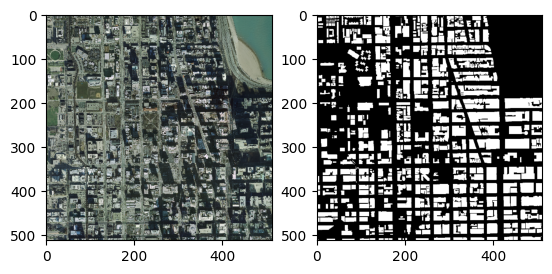

In [10]:
plt.subplot(1,2,1)
plt.imshow(X_train[65])

plt.subplot(1,2,2)
plt.imshow(y_train[65], cmap='gray')

In [11]:
# Load and preprocess GeoTIFF, image data as X test
X_test = load_geotiff_data(test_images_dir, target_shape=target_shape, normalize=True)

In [12]:
X_test.shape

(180, 512, 512, 3)

In [13]:
# Convert ground truth masks to binary format
X_test_classified = np.where(X_test > threshold, 1, 0).astype('float32')

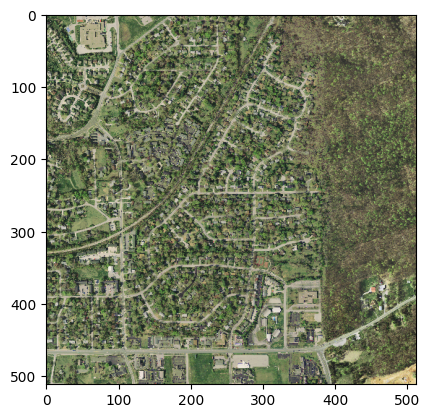

In [14]:
plt.imshow(X_test[65])

# Base Model (Testing)

In [15]:
# Base CNN Model

def initialize_model():
    model = models.Sequential()
    
    model.add(layers.Conv2D(16, (5,5), input_shape=target_shape, padding='same', activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(32, (4,4), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, (3,3), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    model.add(layers.Conv2D(64, (2,2), activation="relu"))
    model.add(layers.MaxPool2D(pool_size=(2,2)))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(64, activation='relu'))
    
    model.add(layers.Dense(1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    
    return model

In [16]:
# Training the CNN

model = initialize_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 512, 512, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 256, 256, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 32)      8224      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 126, 126, 32)     0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 62, 62, 64)       0

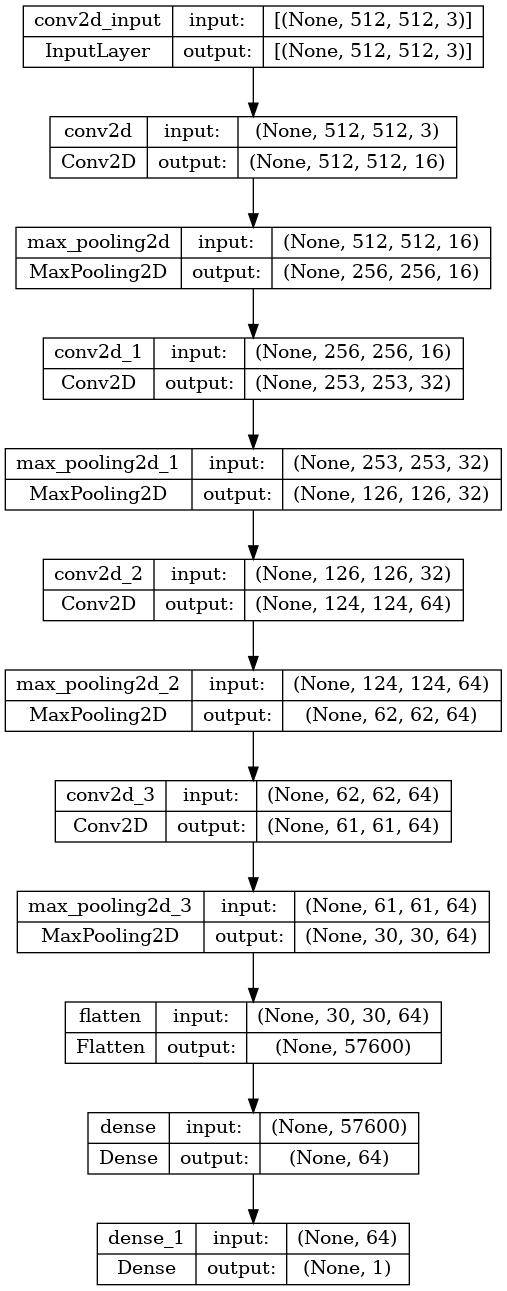

In [17]:
tensorflow.keras.utils.plot_model(model, "base_model.png", show_shapes=True)

In [18]:
# Preprocess the ground truth masks for training set
threshold = 0.5  # Threshold value for binarization
y_train_classified = (y_train > threshold).astype('float32')

# Reshape the ground truth masks to match the model's output shape
y_train_classified = np.reshape(y_train_classified, (-1, 1))

In [19]:
y_train_classified.shape

(47185920, 1)

In [20]:
%%time

es = EarlyStopping(patience = 5,restore_best_weights=True)

# Fit the model on the train data
history = model.fit(
    X_train_classified,
    y_train_classified,
    validation_split=0.2,
    epochs=20,
    batch_size=16,
    verbose=1, 
    callbacks = [es] # This will call the Early Stopping Criterion for each epoch
)

Epoch 1/20
9/9 [==============================] - 23s 2s/step - loss: 1.0522 - accuracy: 0.8264 - val_loss: 0.5003 - val_accuracy: 0.8056
Epoch 2/20
9/9 [==============================] - 30s 3s/step - loss: 0.5131 - accuracy: 0.8264 - val_loss: 0.4887 - val_accuracy: 0.8056
Epoch 3/20
9/9 [==============================] - 28s 3s/step - loss: 0.4678 - accuracy: 0.8264 - val_loss: 0.4840 - val_accuracy: 0.8056
Epoch 4/20
9/9 [==============================] - 24s 3s/step - loss: 0.4485 - accuracy: 0.8264 - val_loss: 0.5473 - val_accuracy: 0.8056
Epoch 5/20
9/9 [==============================] - 25s 3s/step - loss: 0.4013 - accuracy: 0.8264 - val_loss: 0.5419 - val_accuracy: 0.8056
Epoch 6/20
9/9 [==============================] - 34s 4s/step - loss: 0.3790 - accuracy: 0.8264 - val_loss: 0.5617 - val_accuracy: 0.8056
Epoch 7/20
9/9 [==============================] - 21s 2s/step - loss: 0.2999 - accuracy: 0.8750 - val_loss: 0.4498 - val_accuracy: 0.8056
Epoch 8/20
9/9 [==================

In [21]:
baseline_score = np.mean(history.history['accuracy']).round(2)
baseline_score

0.9

In [22]:
def plot_loss_accuracy(history, title=None):
    fig, ax = plt.subplots(1,2, figsize=(20,7))
    
    # --- LOSS --- 
    
    ax[0].plot(history.history['loss'])
    ax[0].plot(history.history['val_loss'])
    ax[0].set_title('Model loss')
    ax[0].set_ylabel('Loss')
    ax[0].set_xlabel('Epoch')
    ax[0].legend(['Train', 'Val'], loc='best')
    ax[0].grid(axis="x",linewidth=0.5)
    ax[0].grid(axis="y",linewidth=0.5)
    
    # --- ACCURACY
    
    ax[1].plot(history.history['accuracy'])
    ax[1].plot(history.history['val_accuracy'])
    ax[1].set_title('Model Accuracy')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_xlabel('Epoch')
    ax[1].legend(['Train', 'Val'], loc='best')
    ax[1].grid(axis="x",linewidth=0.5)
    ax[1].grid(axis="y",linewidth=0.5)
    
    if title:
        fig.suptitle(title)

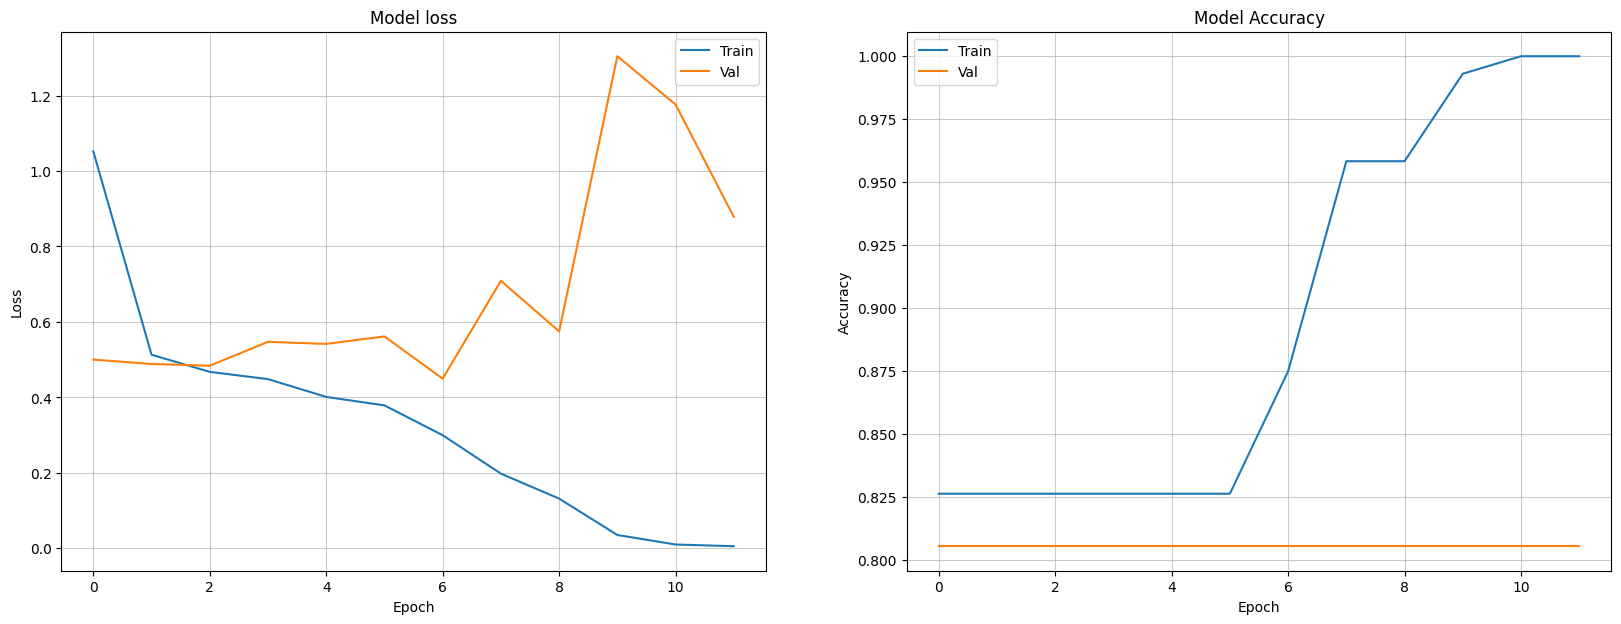

In [23]:
plot_loss_accuracy(history)

# Prediction from Base Model

In [24]:
# Predict the masks for the test images
y_pred_model = model.predict(X_test)

6/6 [==============================] - 4s 551ms/step


In [25]:
y_pred_model[1]

array([0.16133612], dtype=float32)

In [26]:
y_pred_model.max()

0.25582895

In [27]:
# An empty array for y_pred_classified
y_pred_classified = np.empty((len(X_test), *target_shape[:2], 1), dtype='float32')

# Assign values from y_pred to y_pred_classified
for i in range(len(y_pred_model)):
    y_pred_classified[i] = y_pred_model[i]

In [28]:
y_pred_classified.shape

(180, 512, 512, 1)

In [29]:
y_pred_classified

array([[[[0.13936627],
         [0.13936627],
         [0.13936627],
         ...,
         [0.13936627],
         [0.13936627],
         [0.13936627]],

        [[0.13936627],
         [0.13936627],
         [0.13936627],
         ...,
         [0.13936627],
         [0.13936627],
         [0.13936627]],

        [[0.13936627],
         [0.13936627],
         [0.13936627],
         ...,
         [0.13936627],
         [0.13936627],
         [0.13936627]],

        ...,

        [[0.13936627],
         [0.13936627],
         [0.13936627],
         ...,
         [0.13936627],
         [0.13936627],
         [0.13936627]],

        [[0.13936627],
         [0.13936627],
         [0.13936627],
         ...,
         [0.13936627],
         [0.13936627],
         [0.13936627]],

        [[0.13936627],
         [0.13936627],
         [0.13936627],
         ...,
         [0.13936627],
         [0.13936627],
         [0.13936627]]],


       [[[0.16133612],
         [0.16133612],
         [0.16

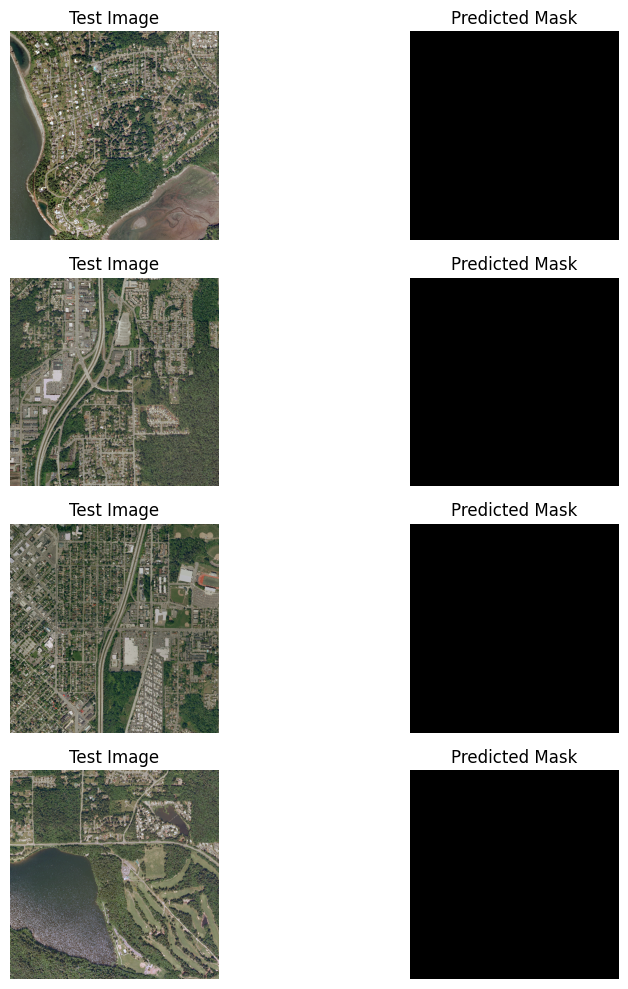

In [30]:
# Plot test RGB images and predicted masks side by side
fig, axes = plt.subplots(4, 2, figsize=(10, 10))

for i in range(4):
    # Plot test RGB image
    axes[i, 0].imshow(X_test[i])
    axes[i, 0].axis('off')
    axes[i, 0].set_title('Test Image')

    # Plot predicted mask
    axes[i, 1].imshow(y_pred_classified[i].squeeze(), cmap='gray')
    axes[i, 1].axis('off')
    axes[i, 1].set_title('Predicted Mask')

plt.tight_layout()
plt.show()